# 1. Import Libraries

In [3]:
#Import the required libraries.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import scipy
from statsmodels import robust
from scipy.stats import skew
from scipy.stats import kurtosis
from tqdm import tqdm
from scipy import signal
import lightgbm as lgb
import pickle
import os
import joblib
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [8]:
#load the raw data
df = pd.read_csv('train.csv')
pd.options.display.precision = 12
df.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


# 2. Function 1
### Function to predict the remaining time to the earthquake of the given acoustic signal.

In [13]:
def final_fuction_1(x):


    '''This function takes raw data as acoustic signal value with the 150k data points as input and returns the remaining time of the next earthquake.'''

    features = {}
    image_pixel_feature = []
    pixel_intensity = []
    features['average_value'] = x.values.mean()
    features['std_value'] = x.values.std()
    features['max_value'] = x.values.max()
    features['min_value'] = x.values.min()
    features['kurtosis']  = x.kurtosis()
    features['skew'] = x.skew()
    features['MAD_value'] = robust.mad(x.values)
    #take absolute values
    features['abs_average_value'] = np.abs(x.values).mean()
    features['abs_std_value'] = np.abs(x.values).std()
    features['abs_max_value'] = np.abs(x.values).max()
    features['abs_median'] = np.median(np.abs(x.values))
    #take top 3 quantile
    features['99_quantile'] = np.quantile(x.values, 0.99)
    features['95_quantile'] = np.quantile(x.values, 0.95)
    features['90_quantile'] = np.quantile(x.values, 0.90)
    #take low 3 quantile
    features['01_quantile'] = np.quantile(x.values, 0.01)
    features['05_quantile'] = np.quantile(x.values, 0.05)
    features['10_quantile'] = np.quantile(x.values, 0.10)
    #take interquantile range
    features['interquantile'] = np.quantile(x.values, 0.27) - np.quantile(x.values, 0.25)
    #mean and std of last and first 5k datapoints
    features['mean_of_first_50000'] = x[:50000].values.mean()
    features['mean_of_last_50000'] = x[:-50000].values.mean()
    
    for i in [10,50,100,150,200]:
        rolling_mean = x.rolling(i).mean().shift().dropna().values
        rolling_std = x.rolling(i).std().shift().dropna().values

        features['avg_of_'+ str(i)+'_rolling_mean'] = rolling_mean.mean()
        features['std_of_'+ str(i)+'_rolling_mean'] = rolling_mean.std()
        features['1_qua_of_'+ str(i)+'_rolling_mean'] = np.quantile(rolling_mean, 0.01)
        features['5_qua_of_'+ str(i)+'_rolling_mean'] = np.quantile(rolling_mean, 0.05)
        features['90_qua_of_'+ str(i)+'_rolling_mean'] = np.quantile(rolling_mean, 0.90)
        features['95_qua_of_'+ str(i)+'_rolling_mean'] = np.quantile(rolling_mean, 0.95)
        features['skew_of'+ str(i)+'_rolling_mean'] = skew(rolling_mean)
        features['kurtosis_of'+ str(i)+'_rolling_mean'] = kurtosis(rolling_mean)
        features['min_of'+ str(i)+'_rolling_mean'] = rolling_mean.min()
        features['max_of'+ str(i)+'_rolling_mean'] = rolling_mean.max()
        features['interquantile_of' + str(i)+'_rolling_mean'] = np.quantile(rolling_mean, 0.27) - np.quantile(rolling_mean, 0.25)

        features['avg_of_'+ str(i)+'_rolling_std'] = rolling_std.mean()
        features['std_of_'+ str(i)+'_rolling_std'] = rolling_std.std()
        features['1_qua_of_'+ str(i)+'_rolling_std'] = np.quantile(rolling_std, 0.01)
        features['5_qua_of_'+ str(i)+'_rolling_std'] = np.quantile(rolling_std, 0.05)
        features['90_qua_of_'+ str(i)+'_rolling_std'] = np.quantile(rolling_std, 0.90)
        features['95_qua_of_'+ str(i)+'_rolling_std'] = np.quantile(rolling_std, 0.95)
        features['skew_of'+ str(i)+'_rolling_std'] = skew(rolling_std)
        features['kurtosis_of'+ str(i)+'_rolling_std'] = kurtosis(rolling_std)
        features['min_of'+ str(i)+'_rolling_std'] = rolling_std.min()
        features['max_of'+ str(i)+'_rolling_std'] = rolling_std.max()
        features['interquantile_of' + str(i)+'rolling_std'] = np.quantile(rolling_std, 0.27) - np.quantile(rolling_std, 0.25)
    feature_df = pd.DataFrame(features , index=[0])
        
    frequencies, times, spectrogram = signal.spectrogram(x)
    pixel_intensity.append(spectrogram.flatten()[:500])
    for i in range(500):
        image_pixel_feature.append('PI' + str(i))
    img_df = pd.DataFrame(pixel_intensity , columns = image_pixel_feature)
    result = pd.concat([feature_df , img_df], axis=1, join="inner")
    #print(result)
    
    model = joblib.load('model.pkl')
    predict = model.predict(result)
    return predict[0]

In [58]:
#load the submission files
file = os.listdir('test')

In [63]:
file_name = []
predict_value = []
for i in file:
    csv = pd.read_csv('test/' + i)
    pre = final_fuction_1(csv)
    predict_value.append(pre)
    file_name.append(i.split('.')[0])

test = pd.DataFrame()
test['seg_id'] = file_name
test['time_to_failure'] = predict_value
print('First 10 test values')
test.head(10)

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  .format(nperseg, input_length))


First 10 test values


,seg_id,time_to_failure
0,seg_91fc29,4.086350737801
1,seg_3bf9ac,3.559697400345
2,seg_fdd50e,4.182634120947
3,seg_5bfbf0,4.713009147515
4,seg_3706be,9.372532944312
5,seg_a420d4,4.572280076521
6,seg_660fef,7.878057238005
7,seg_7ebdc3,5.594973117422
8,seg_1d044c,5.342727186881
9,seg_15bf25,9.949539091456


# 3. Function 2
### Function to calculate the performance metrics and show the values of the given raw data

In [2]:
def final_fuction_2(x , y):
    sample_value = 150000
    size = len(x) // sample_value
    actual_y = []
    predict_y = []
    for i in (range(size)):
        X = x[i*sample_value :i*sample_value + sample_value]
        Y = y[i*sample_value :i*sample_value + sample_value]
        actual_y.append(Y.values[-1])
        predict_y.append(final_fuction_1(X))

    return print('The mean absolute error is {} and The mean absolute percentage error is {} on the row data.'.format(mean_absolute_error(actual_y, predict_y) , mean_absolute_percentage_error(actual_y, predict_y)))

In [51]:
#load the raw data
x = df.acoustic_data
y = df.time_to_failure

In [53]:
final_fuction_2(x , y)

The mean absolute error is 1.2279812288577636 and The mean absolute percentage error is 2.102233799325241 on the row data.


## Web app

Link of web app https://share.streamlit.io/shivambaldha/earthquake-prediction/main/app.py

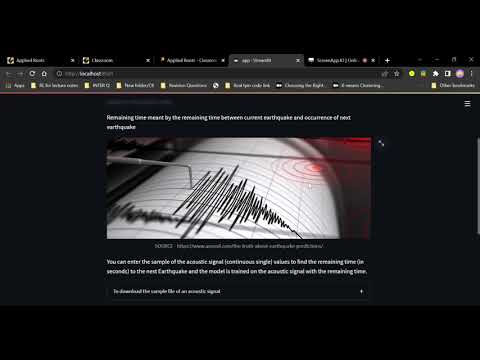

In [7]:
#code taken from https://stackoverflow.com/questions/51178699/trying-to-display-youtube-video-in-jupyter-notebook
from IPython.display import YouTubeVideo

YouTubeVideo('_W1WXxQEcpI', width=800, height=800)